In [25]:
import jax.numpy as jnp
import jax
import cryojax as cx
import simple_simulator as sim
import os

import numpyro
import numpyro.distributions as dist

import logging
from functools import partial

import matplotlib.pyplot as plt


# Create list of pdb files for simulating images from

In [26]:
path_to_models="data/hsp90_models"
model_fnames = []
for model_fname in sorted(os.listdir(path_to_models)):
    model_fnames.append(model_fname)


# Define a weight distribution on the pdb files
## Here, evaluating a gaussian mixture pdf on the indices of the pdbs

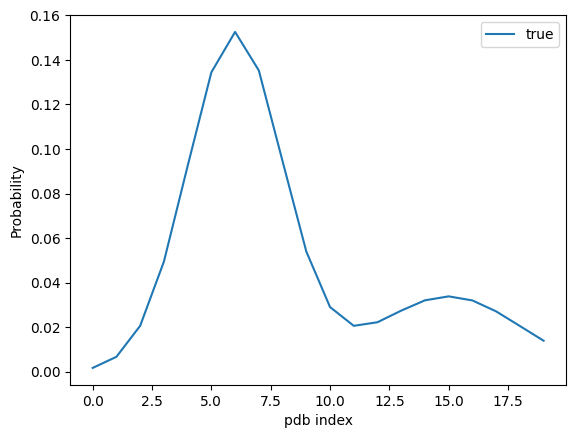

In [27]:
def GaussianMixture1D(weights, means, std_devs):
    weights = jnp.array(weights)
    means = jnp.array(means)
    std_devs = jnp.array(std_devs)
    mixing_dist = dist.Categorical(probs=weights/jnp.sum(weights))
    component_dist = dist.Normal(loc=means, scale=std_devs) 
    return dist.MixtureSameFamily(mixing_dist, component_dist) 

weights = [1., 1./3.]
means = [6., 15.]
std_devs = [2.0, 3.0]
mixture = GaussianMixture1D(weights, means, std_devs)
samples = mixture.sample(jax.random.PRNGKey(0), (10000,))
 
# compute pdf output on a 1d grid
x = jnp.linspace(0, 19, 20)
dx = x[1] - x[0]
    
# normalize output to integrate to 1 on the grid 
weights = jnp.exp(mixture.log_prob(x))
weights /= dx*weights.sum() 
plt.plot(x, weights, label='true', color="C0")
plt.xlabel('pdb index')
plt.ylabel('Probability')  
plt.legend()
plt.show()


# Define a config file for image simulation

In [28]:
# Bare bones config for this notebook
# Things that may need to be adjusted:
#   number of images, noise_snr
# Everything else, unlikely

config = {
"number_of_images": 1000,
"noise_snr": 0.1,
"weights_models": weights,
"models_fnames": model_fnames, 
"path_to_models": path_to_models, 
"box_size": 128,
"rng_seed": 0,
"pixel_size": 1.6,
}

In [29]:
# Create static image formation stuff
imaging_args = sim.build_image_formation_stuff(config)

# Create noise stuff
noise_grid = jnp.linspace(
                 -0.5 * (config["box_size"] - 1),
                 0.5 * (config["box_size"] - 1),
                 config["box_size"],
             )
noise_radius = 0.5*config["box_size"] - 1 # For now, using a disc that is radius of the image for SNR calculations
noise_args = noise_grid, noise_radius, config["noise_snr"] 

def get_pipeline_info(imaging_pipeline):
    """Custom function for returning various stats from an imaging pipeline"""
    info = {}
    info["conformation"] = imaging_pipeline.scattering_theory.structural_ensemble.conformation.value  
    #info["..."] = ...

    return info

# NOTE: here there is no argument at all for weights, since the weights aren't being sampled here
def sample_images(key, config, imaging_args, noise_args):

    # Generate RNG keys for individual images
    key, *subkeys = jax.random.split(key, config["number_of_images"] + 1)
    subkeys = jnp.array(subkeys)
    
    # Pipeline
    imaging_pipeline = sim.make_imaging_pipeline(subkeys, imaging_args)
    extra_info = get_pipeline_info(imaging_pipeline)

    noised_images, noise_power_sq = sim.compute_image_stack_with_noise(key, config, imaging_pipeline, noise_args)

    return noised_images, extra_info



# Simulate a dataset!

In [30]:
key = jax.random.PRNGKey(config["rng_seed"])
noised_images, extra_info = sample_images(key,config, imaging_args, noise_args)


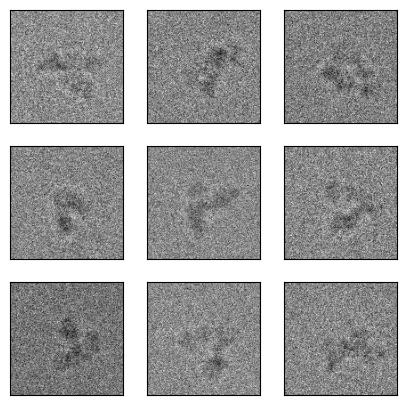

In [31]:
fig, axes = plt.subplots(3, 3, figsize=(5, 5))
for idx, ax in enumerate(axes.reshape(-1)):
    ax.imshow(noised_images[idx,:], cmap="gray")
    ax.set_yticks([])
    ax.set_xticks([])
#plt.savefig(f"figures/noised_images", dpi=300)


Checking the conformation idx of each individual image

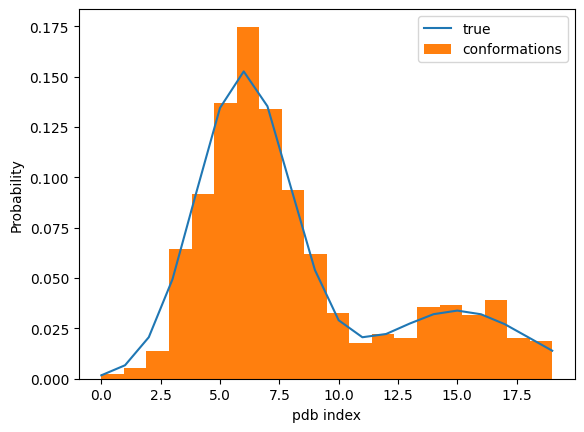

In [37]:
conformations = extra_info["conformation"]
# compute pdf output on a 1d grid
x = jnp.linspace(0, 19, 20)
dx = x[1] - x[0]
    
# normalize output to integrate to 1 on the grid 
weights = jnp.exp(mixture.log_prob(x))
weights /= weights.sum()
plt.plot(x, weights, label='true', color="C0")
plt.hist(conformations, bins=20, range=(0, 19), density=True, label='conformations', color="C1")
plt.xlabel('pdb index')
plt.ylabel('Probability')  
plt.legend()
plt.show()
